# Tesla Stocks Data

In [1]:
import pandas as pd

#%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#importar celdas recurrentes, noten que se reutiliza la implementacion de TF1
from tensorflow.compat.v1.nn import rnn_cell
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout


### Data Loading

In [2]:
tsla_df = pd.read_csv(r"C:\Users\berna\Documents\ML Project-CS50 Final\Finance-CompanyStocks\Transformed Data\tesla_stocks_transformed.csv")

In [3]:
# CARGA DE DATOS

date = []
high = []
low = []
close_prices = []
vol = []

for index, row in tsla_df.iterrows():
    date.append(row['date'])
    high.append(row['high'])
    low.append(row['low'])
    close_prices.append(row['close'])
    vol.append(row['volume'])

print(f'Se tienen {len(date)} tuplas')

Se tienen 9592 tuplas


In [4]:
# FUNCIÓN DE PARTICIÓN DE LOS DATOS
def data_generator(data, window, distance=0):
    x = []
    y = []
    for i in range(len(data) - window - distance):
        # Extract multiple columns for input features 
#         features = data.iloc[i:i+window][['close', 'volume', 'momentum_rsi', 'trend_macd']]
        features = data.iloc[i:i+window][['close']]

        x.append(features.values)  # Append multiple columns as input features
        y.append(data.iloc[i+window+distance]['close'])  # Target variable (close_prices)
    return np.array(x), np.array(y)


# Para prediccion solo de test
# def representacion_grafica(mensaje, predic_block_epochs, real_data, trained_data):
#     plt.figure(figsize=(18, 9))

# #     plt.plot(range(len(date[:len(predic_block_epochs)])), real_data['close'][:len(predic_block_epochs)], label='Normalized Close Prices')
#     plt.plot(range(len(date[100:100+trained_data+len(predic_block_epochs)])), real_data['close'][100:100+trained_data+len(predic_block_epochs)], label='Normalized Close Prices')
# #     plt.plot(range(len(date[:trained_data])), predic_block_epochs[:trained_data], color="yellow", label='Train Predictions')

#     # Plotting test predictions (starting from trained_data to the end of predictions)
#     start_test_index = trained_data
# #     end_test_index = trained_data + len(predic_block_epochs[trained_data:])
# #     plt.plot(range(start_test_index, end_test_index), predic_block_epochs[trained_data:], color="green", label='Test Predictions')
#     plt.plot(range(start_test_index, trained_data+len(predic_block_epochs)), predic_block_epochs, color="green", label='Test Predictions')

#     plt.xticks(range(0, len(date), 500), date[0::500], rotation=45)

#     plt.title(mensaje, fontsize=25)
#     plt.xlabel('Fecha', fontsize=18)
#     plt.ylabel('Normalized Close Prices', fontsize=18)

#     plt.grid(axis='y', color='gray', linestyle='dashed')
#     plt.legend()
#     plt.show()

# Para prediccion completa

def representacion_grafica(mensaje, predictions, real_data, trained_data):
    plt.figure(figsize=(18, 9))

    plt.plot(range(len(date[100:100+len(predictions)])), real_data['close'][100:100+len(predictions)], label='Normalized Close Prices')
    plt.plot(range(len(date[:trained_data])), predictions[:trained_data], color="yellow", label='Train Predictions')

    # Plotting test predictions (starting from trained_data to the end of predictions)
    start_test_index = trained_data
    end_test_index = trained_data + len(predictions[trained_data:])
    plt.plot(range(start_test_index, end_test_index), predictions[trained_data:], color="green", label='Test Predictions')

    plt.xticks(range(0, len(date), 500), date[0::500], rotation=45)

    plt.title(mensaje, fontsize=25)
    plt.xlabel('Fecha', fontsize=18)
    plt.ylabel('Normalized Close Prices', fontsize=18)

    plt.grid(axis='y', color='gray', linestyle='dashed')
    plt.legend()
    plt.show()

    
def representacion_grafica_onlyPred(mensaje, predictions, real_data, trained_data):
    plt.figure(figsize=(18, 9))

    # Plotting test predictions with respective dates
    start_test_index = 100 + trained_data  # Adjusting start index based on initial data slice
    end_test_index = 100 + trained_data + len(predictions[trained_data:])

    plt.plot(range(start_test_index, end_test_index), real_data['close'][start_test_index:end_test_index], label='Normalized Close Prices (Test)')
    plt.plot(range(start_test_index, end_test_index), predictions[trained_data:], color="green", label='Test Predictions')

    plt.xticks(range(start_test_index, end_test_index, 500), date[start_test_index:end_test_index:500], rotation=45)

    plt.title(mensaje, fontsize=25)
    plt.xlabel('Fecha', fontsize=18)
    plt.ylabel('Normalized Close Prices', fontsize=18)

    plt.grid(axis='y', color='gray', linestyle='dashed')
    plt.legend()
    plt.show()

    
#Calculo del error Absoluto
def ErrorAbs(dataOriginal, dataPredic):
    if dataPredic.ndim == 2:
        dataPredic = np.squeeze(dataPredic)
        Error_Abs = np.subtract(dataOriginal, dataPredic)
        Error_Abs = np.absolute(Error_Abs)
    return Error_Abs

##
def ErrorRel(dataOriginal, dataErrorAbs):
    if dataErrorAbs.ndim == 2:
        dataErrorAbs = np.squeeze(dataErrorAbs)
    return np.divide(dataErrorAbs, dataOriginal)

##
def grafica_error_relativo(predic_block_epochs, ErrorRel_predic, mensaje, data):
    data_start = len(data['close'][100:100+len(predic_block_epochs)]) - Test_size
    data_end = len(data['close'][100:100+len(predic_block_epochs)])

    plt.figure(figsize = (18,9))

    plt.plot(range(data_start, data_end), ErrorRel_predic[data_start:data_end]*100, "y", marker="x", label='Close Price Prediction')

    plt.xticks( range(data_start, data_end, len(date[data_start: data_end])//10),
            data['date'][data_start:data_end:len(date[data_start:data_end])//10],
            rotation=45)

    plt.xticks(rotation=45)
    plt.title(mensaje, fontsize=25)
    plt.xlabel('Date',fontsize=18)
    plt.ylabel('Error Relativo [%]',fontsize=18)

    plt.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
    plt.legend()
    plt.show()

In [5]:
# Cambiar segun el porcentaje de los datos (Puede que el tamaño de los datos no coincida con los indices usados) #
def proporcionalidad(datos_reales, datos_predic):
    prop_1 = datos_reales[100]-datos_reales[101]
    prop_2 = datos_predic[100]-datos_predic[101]

    # prop_3 = datos_reales[200]-datos_reales[201]
    # prop_4 = datos_predic[200]-datos_predic[201]

    # Para los primeros 4 puntos
    if(prop_1 < 0):
        res_1 = 0
    else:
        res_1 = 1

    if(prop_2 < 0):
        res_2 = 0
    else:
        res_2 = 1

    if(res_1 == res_2):
        return 0 # puntos_1 = 0
    else:
        return 1 # puntos_1 = 1
    
def post_processing_process(predictions, df):
    # Calcular puntos medios de las graficas y modificar las predicciones al punto medio de los datos reales

    print("Midpoints:")
    midpoint1 = np.min(Test_data['close']) + (np.max(Test_data['close'])-np.min(Test_data['close']))/2   # Midpoint de datos reales
    midpoint2 = np.min(predictions) + (np.max(predictions)-np.min(predictions))/2    # Midpoint de datos de prediccion

    predictions = predictions + (midpoint1 - midpoint2)
    midpoint3 = np.min(predictions) + (np.max(predictions)-np.min(predictions))/2    # Midpoint de datos de prediccion despues de modificacion

    # Relacion entre maximos y minimos
    alpha1 = (np.max(Test_data['close'])-np.min(Test_data['close'])) / (np.max(predictions)-np.min(predictions))
    print(f"Alpha: {alpha1}")
    #----Calculos de beta------#

    beta1 = (midpoint3*alpha1)-midpoint3 # Con midpoint de las predicciones por alpha
    print(f"Beta: {beta1}")
    if(alpha1 < 1):
        sign = 1
    else:
        sign = -1

    predictions = predictions*alpha1+(sign*beta1)
#     predictions = predictions*alpha1+beta1

    # Modificar si es inversamente proporcional

    
    if(proporcionalidad(df['close'], predictions) == 0):
        print("Proporcional")
#         predictions = predictions * -1 + midpoint3*2 # Con midpoint de datos reales
    else:
        print("They're not proportional?")
#         predictions = predictions * -1 + midpoint3*2 # Con midpoint de datos reales
    
    return predictions
    

### Data Partition and Preparation

In [6]:
# 80% de datos para entrenamiento
Train_size = int(len(close_prices) * 0.70)

# predict the next 15% of the total data
Test_size = int(len(close_prices) * 0.25)

Validation_size = len(close_prices) - Train_size - Test_size

print(f"Train: {Train_size} \t Test: {Test_size} \t Validation: {Validation_size} \t Total {len(close_prices)}")

# Generación de los vectores de datos
Train_data = tsla_df[:Train_size]
Validation_data = tsla_df[Train_size+Test_size:]
# Test_data = tsla_df[Train_size:Train_size+Test_size]
Test_data = tsla_df[:Train_size+Test_size]

# DEFINICIÓN DEL PAQUETE DE DATOS
Size_Block = 100

# Generación de las ventanas de analisis
train_x,train_y=data_generator(Train_data, Size_Block , 0)

print(f'\n Datos de entrenamiento: \t Train_x: {train_x.shape} \t Train_y: {train_y.shape}')

test_x,test_y=data_generator(Test_data, Size_Block , 0)

print(f'\n Datos de prueba: \t Test_x: {test_x.shape} \t Test_y: {test_y.shape}')

validation_x,validation_y=data_generator(Validation_data, Size_Block , 0)

print(f'\n Datos de validación: \t Validation_x: {validation_x.shape} \t Validation_y: {validation_y.shape}')


# DEFINICIÓN DEL NUMERO DE ATRIBUTOS. Definido en data_generator
n_features = 1  
epocas = 10

train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1],n_features))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1],n_features))

Train: 6714 	 Test: 2398 	 Validation: 480 	 Total 9592

 Datos de entrenamiento: 	 Train_x: (6614, 100, 1) 	 Train_y: (6614,)

 Datos de prueba: 	 Test_x: (9012, 100, 1) 	 Test_y: (9012,)

 Datos de validación: 	 Validation_x: (380, 100, 1) 	 Validation_y: (380,)


### Building the Model

In [7]:
RNN=tf.keras.Sequential()

RNN.add(tf.keras.layers.LSTM(
                        units= 1,
                        input_shape=(Size_Block,n_features),
                        activation="tanh"
))

RNN.add(tf.keras.layers.Dropout(0.3))

RNN.add(tf.keras.layers.Dense(units=1, activation = 'tanh'))

RNN.summary()

RNN.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1)                 12        
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


### Model Training

Epoch 1/10
133/133 [==============================] - 19s 69ms/step - loss: 1.3067e-05 - mean_squared_error: 1.3067e-05 - val_loss: 5.9786e-06 - val_mean_squared_error: 5.9786e-06
Epoch 2/10
133/133 [==============================] - 6s 45ms/step - loss: 1.1002e-05 - mean_squared_error: 1.1002e-05 - val_loss: 3.7840e-06 - val_mean_squared_error: 3.7840e-06
Epoch 3/10
133/133 [==============================] - 6s 48ms/step - loss: 1.0850e-05 - mean_squared_error: 1.0850e-05 - val_loss: 3.5442e-06 - val_mean_squared_error: 3.5442e-06
Epoch 4/10
133/133 [==============================] - 6s 47ms/step - loss: 9.8961e-06 - mean_squared_error: 9.8961e-06 - val_loss: 2.5597e-06 - val_mean_squared_error: 2.5597e-06
Epoch 5/10
133/133 [==============================] - 6s 47ms/step - loss: 9.8764e-06 - mean_squared_error: 9.8764e-06 - val_loss: 6.2174e-06 - val_mean_squared_error: 6.2174e-06
Epoch 6/10
133/133 [==============================] - 7s 52ms/step - loss: 1.0876e-05 - mean_squared_err

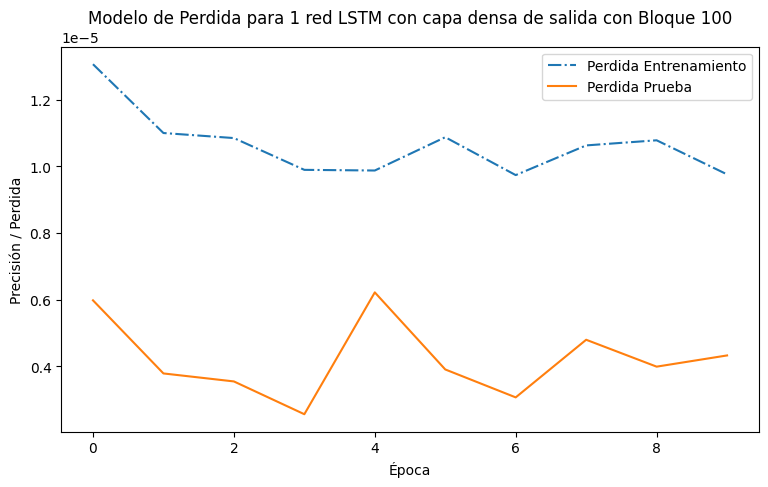

In [8]:
history = RNN.fit( train_x,train_y,
              epochs=epocas,
              batch_size= Size_Block//2,
              shuffle=True,
              callbacks = [early_stop],
              validation_data=(validation_x, validation_y)
              )

# GRAFICA DE CURVAS DE PERDIDA

plt.figure(figsize=(9,5))
plt.plot(history.history['loss'], '-.', label='Perdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Perdida Prueba')

plt.title(f'Modelo de Perdida para 1 red LSTM con capa densa de salida con Bloque {Size_Block}')
plt.xlabel('Época')
plt.ylabel('Precisión / Perdida')
plt.legend()
plt.show()

### Predictions

282/282 [==============================] - 4s 10ms/step


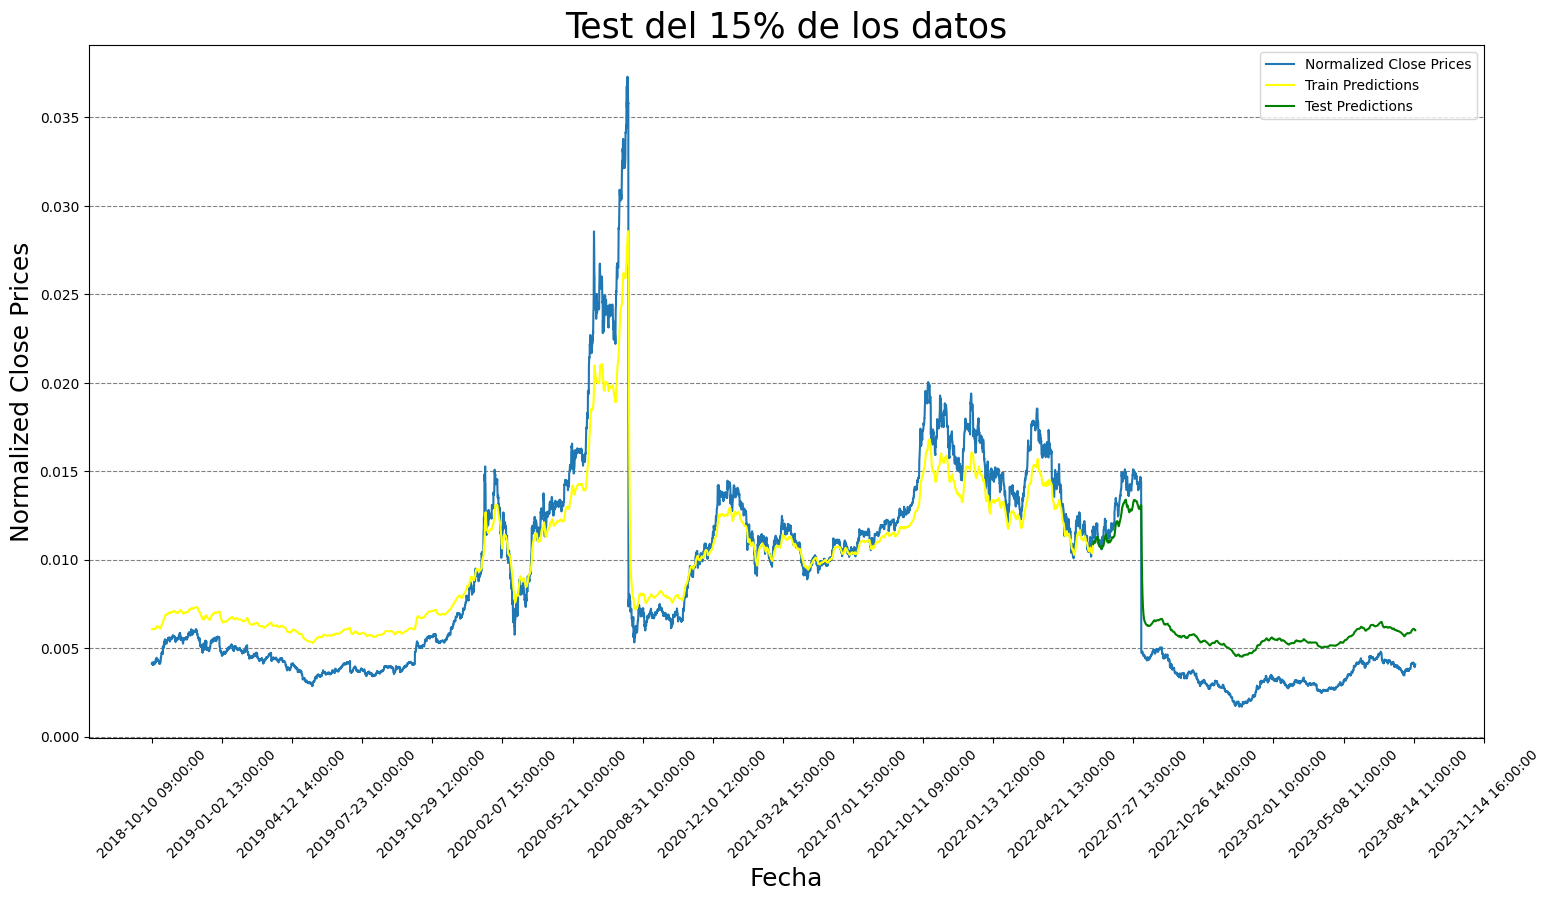

In [9]:
predictions_tsla = RNN.predict(test_x,verbose=True)

#REPRESENTACIÓN GRÁFICA

mensaje = 'Test del 15% de los datos'

representacion_grafica(mensaje, predictions_tsla, tsla_df, Train_size)

### Relative error plotting

Error Abs: 0.02117046204725677
Error Rel: 287.46101363320895


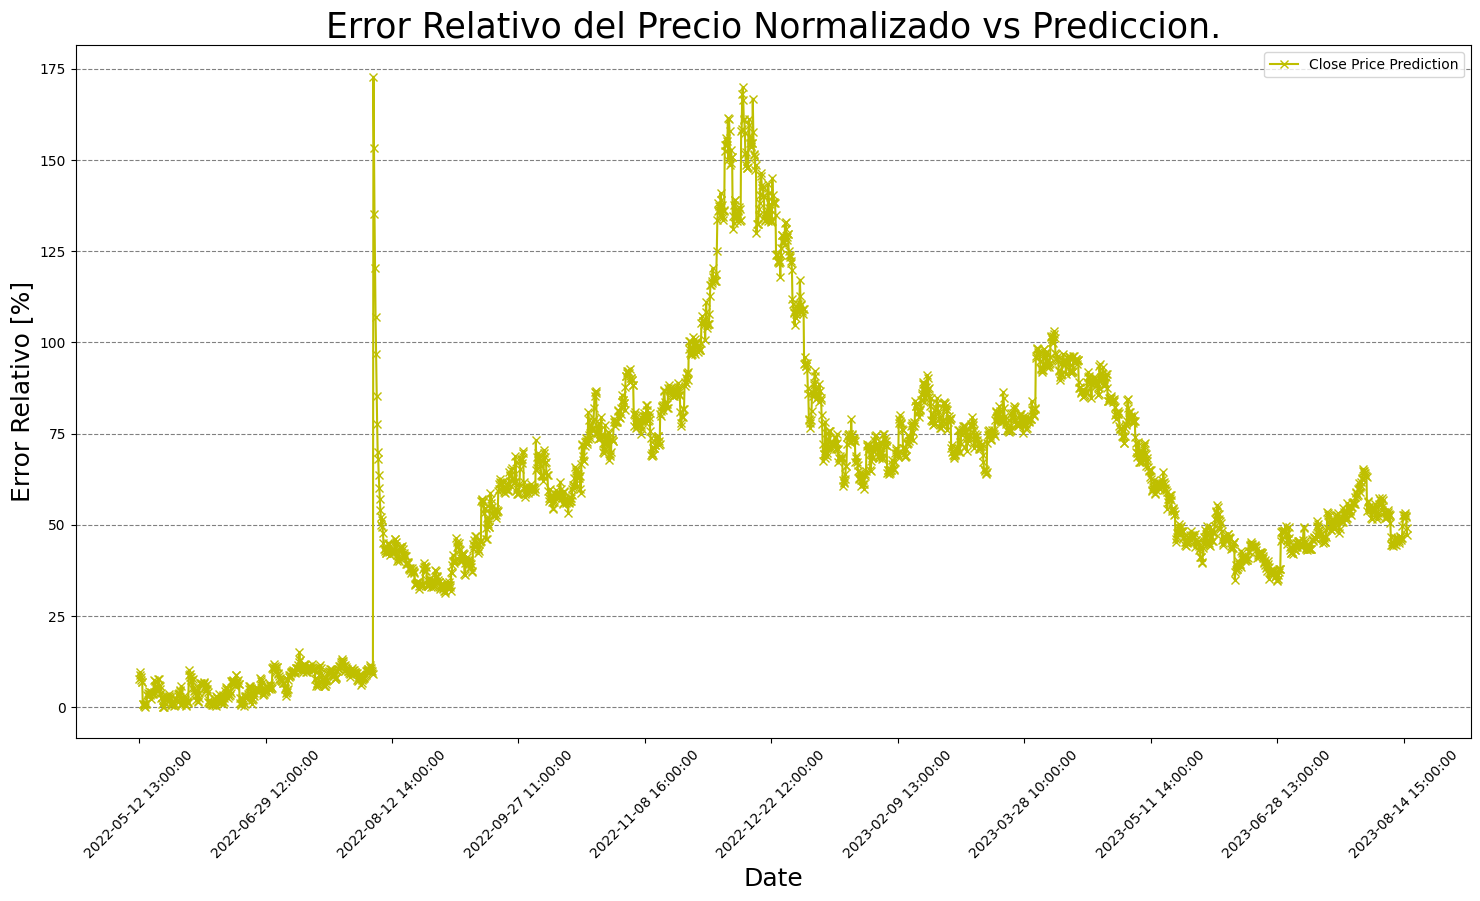

In [10]:
#Calculo del error Absoluto

ErrorAbs_predic_tsla = ErrorAbs(tsla_df['close'][100:100+len(predictions_tsla)], predictions_tsla)
# ErrorAbs_predic_tsla = ErrorAbs(tsla_df['close'][100+Train_size:100+Train_size+len(predictions_tsla)], predictions_tsla)
print(f"Error Abs: {np.max(ErrorAbs_predic_tsla)}")

#Grafica del Error Relativo
ErrorRel_predic_tsla = ErrorRel(tsla_df['close'][100:100+len(predictions_tsla)], ErrorAbs_predic_tsla)
# ErrorRel_predic_tsla = ErrorRel(tsla_df['close'][100+Train_size:100+Train_size+len(predictions_tsla)], ErrorAbs_predic_tsla)
print(f"Error Rel: {np.max(ErrorRel_predic_tsla)*100}")

mensaje = 'Error Relativo del Precio Normalizado vs Prediccion.'
grafica_error_relativo(predictions_tsla, ErrorRel_predic_tsla, mensaje, tsla_df)

### Post-Prediction adjustment

Midpoints:
Alpha: 1.4799628028101302
Beta: 0.009360225840812725
They're not proportional?


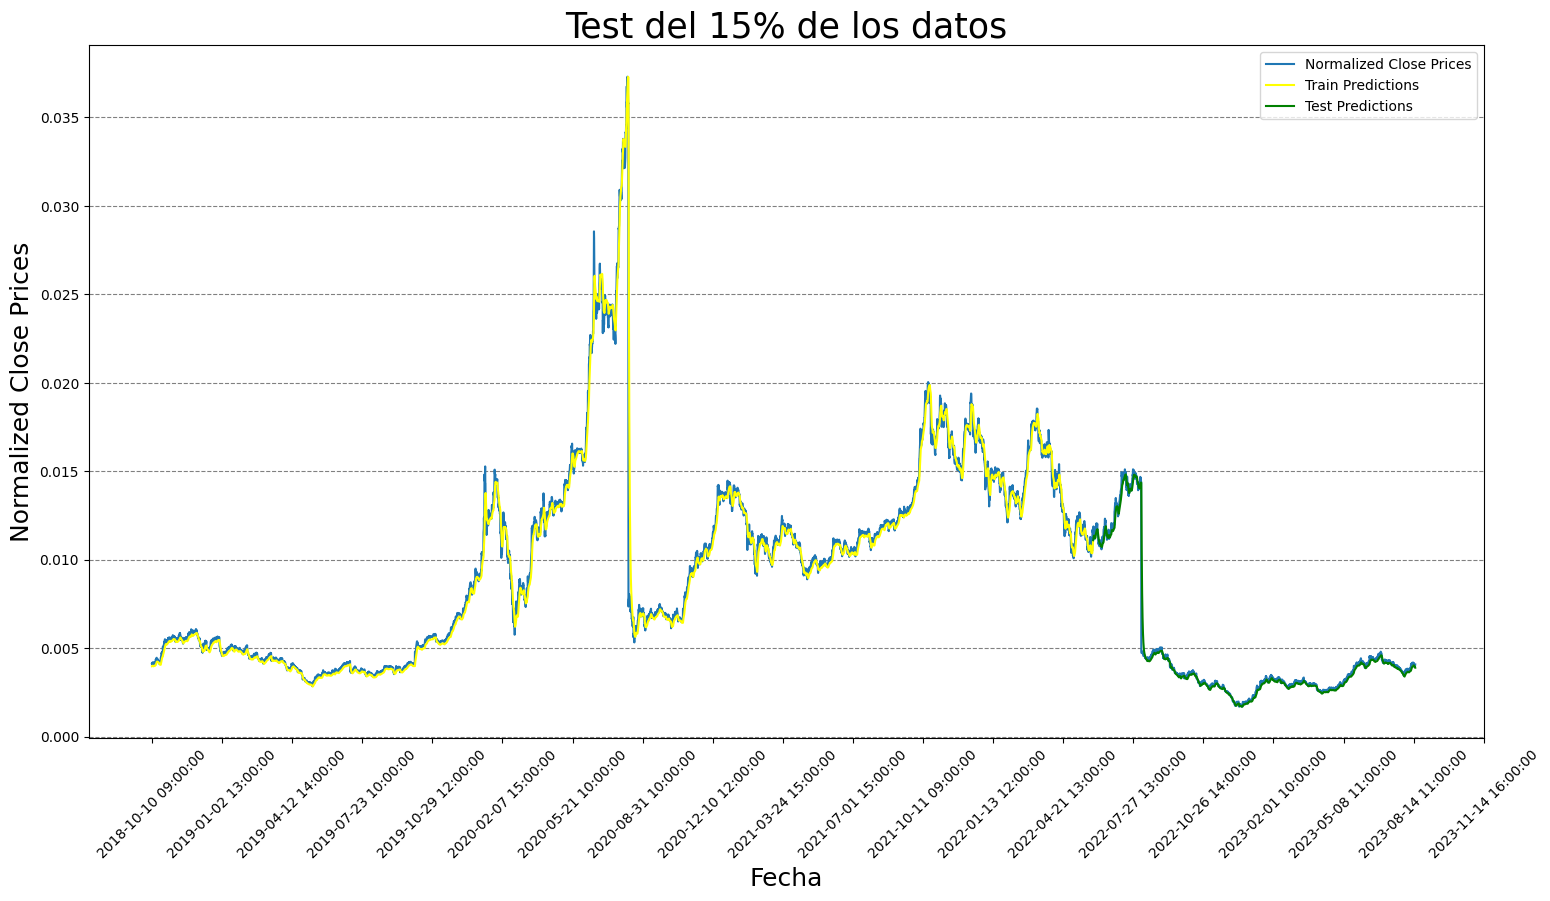

0.029863410194911302
405.49734559458426


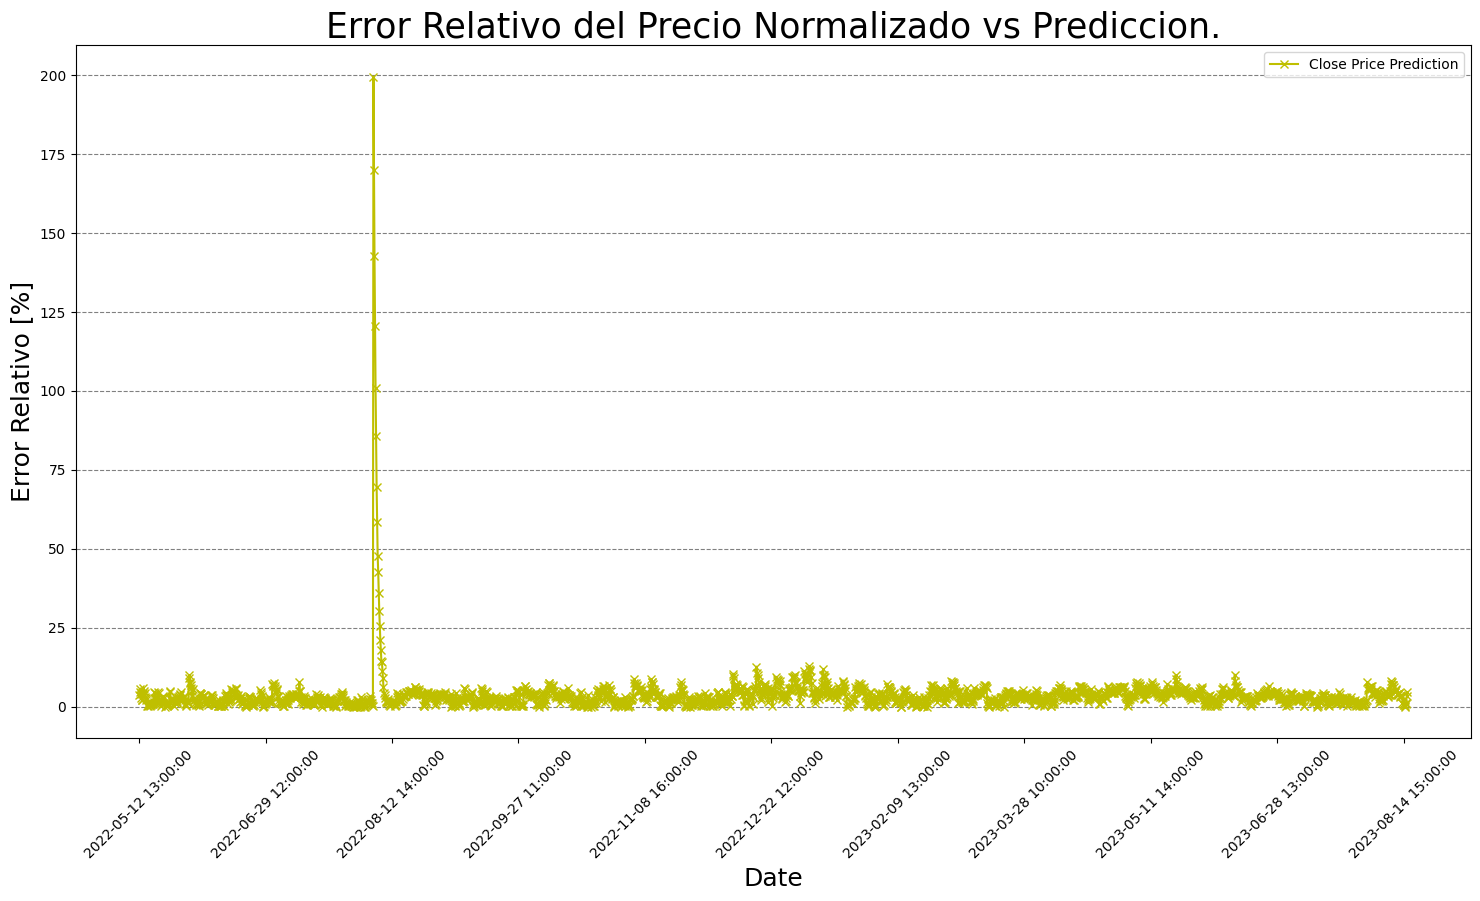

In [11]:
predictions_tsla_adj = post_processing_process(predictions_tsla, tsla_df)

#REPRESENTACIÓN GRÁFICA

mensaje = 'Test del 15% de los datos'
representacion_grafica(mensaje, predictions_tsla_adj, tsla_df, Train_size)

ErrorAbs_predic_tsla = ErrorAbs(tsla_df['close'][100:100+len(predictions_tsla_adj)], predictions_tsla_adj)
print(np.max(ErrorAbs_predic_tsla))

#Grafica del Error Relativo
ErrorRel_predic_tsla = ErrorRel(tsla_df['close'][100:100+len(predictions_tsla_adj)], ErrorAbs_predic_tsla)
print(np.max(ErrorRel_predic_tsla)*100)

mensaje = 'Error Relativo del Precio Normalizado vs Prediccion.'
grafica_error_relativo(predictions_tsla_adj, ErrorRel_predic_tsla, mensaje, tsla_df)

In [12]:
import pickle

with open('tesla_model.pkl', 'wb') as model_file:
    pickle.dump(RNN, model_file)

*Architecture, data processing, graphics and errors obtained from*: 
- Andrade-Gorjoux, L. (2023). Predicción de algunos índices bursátiles en el mercado de valores mexicano usando computación cuántica. En J. Montiel-Perez, Trabajo de Tesis II (Jupyter Notebook). Centro de Investigación en Computación. Instituto Politécnico Nacional.

Not yet published.